In [6]:
import numpy as np
from umap import UMAP
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import glob
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics         import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import AdaBoostClassifier

## Importation des vecteurs encodés

In [ ]:
# Chemin vers le dossier contenant les embeddings de TITAN
path_to_embeds = 'Titan_embeddings\\'

all_tensor=list(glob.iglob(path_to_embeds +'*.pt'))
all_embeds=[]
for tensor in all_tensor:
    embed = torch.load(tensor,map_location=torch.device('cpu')).tolist()[0]
    slide_name = tensor.split('\\')[1][17:53]
    all_embeds.append([slide_name]+embed)
df_embeddings = pd.DataFrame(columns=['ID']+[f'Comp_{i}' for i in range(1, 769)], data=all_embeds)

C:\Users\lasse\AppData\Local\Temp\ipykernel_20052\2524721070.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embed = torch.load(tensor,map_location=torch.device('cpu')).

In [66]:
# Chemin vers le dossier contenant les annotations des lames
path_to_meta = 'INSA_project_slides_anonym.xlsx'

meta=pd.read_excel(path_to_meta, sheet_name="Feuil1", usecols="A,B")
meta['ID'] = meta['NOUVEAU_NOM'].str[:-4]
meta = meta.drop(['NOUVEAU_NOM'], axis = 1)
data = pd.merge(df_embeddings,meta,left_on="ID",right_on="ID")
data = data.dropna()
X = data.iloc[:,1:769]
y = data["BAP1"]

In [67]:
# Pour avoir autant des deux classes:
data_no_bap1=data[data["BAP1"]==0][0:45]
data_bap1=data[data["BAP1"]==4]
data_eq=pd.concat([data_bap1,data_no_bap1])
X = data_eq.iloc[:,1:769]
y = data_eq["BAP1"]

## Visualisation des vecteurs

In [37]:
reducer = UMAP(n_neighbors=30, min_dist=0.1, random_state=42)
X_red=reducer.fit_transform(X)
X_red_df=pd.DataFrame(X_red, index = data.index)
data_red = pd.concat([data.loc[:,"ID"], X_red_df, y], axis = 1)

c:\Users\lasse\anaconda3\envs\conch\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


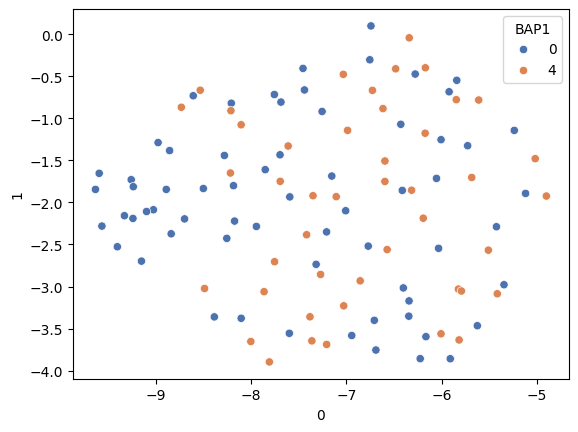

In [40]:
# Visualisation en fonction de BAP1 exprimé ou non 

sns.scatterplot(
   x=0,
   y=1,
   data=data_red,
   hue="BAP1",
   palette = "deep"
)

plt.show()

## Classification des lames

In [70]:
y=y.replace({4 : 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True, stratify=y)

[0.73333333 0.53333333 0.63333333]
Accuracy avec validation croisée LR: 0.633 +- 0.164
Accuracy sur le jeu de test LR: 0.6944444444444444


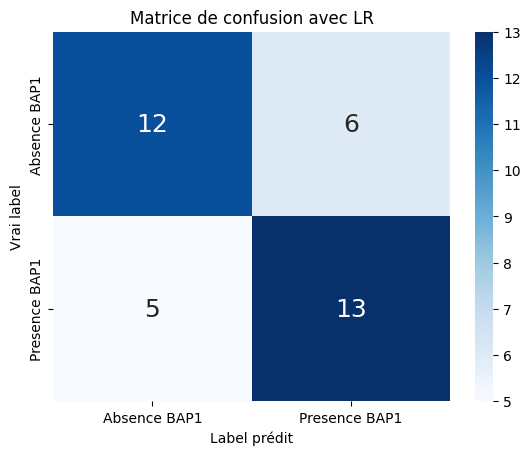

In [71]:
# Logistic regression
lr_clf = LogisticRegression(C=10, penalty='l2', class_weight='balanced',solver="saga",max_iter=1000)

# Validation croisée sur 3 plis
cv = StratifiedKFold(n_splits=3)
scores = cross_validate(lr_clf, X, y, cv=cv, scoring=['accuracy',"recall","f1","precision"])
print(scores["test_accuracy"])
print("Accuracy avec validation croisée LR:", np.mean(scores["test_accuracy"]).round(3), "+-", 2*np.std(scores["test_accuracy"]).round(3))

# Test
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
print(f"Accuracy sur le jeu de test LR: {accuracy_score(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred,labels=[0, 1])
classes=["Absence BAP1", "Presence BAP1"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, xticklabels = classes, yticklabels = classes)
plt.title("Matrice de confusion avec LR")
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.show()

[0.7        0.5        0.63333333]
Accuracy avec validation croisée SVC: 0.611 +- 0.166
Accuracy sur le jeu de test SVC: 0.6666666666666666


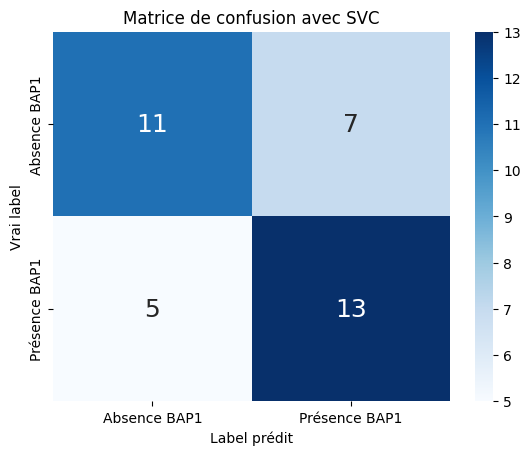

In [75]:
# Support Vector Classifier
svc_clf = SVC(kernel='linear', C=1000)

# Validation croisée sur 3 plis
cv = StratifiedKFold(n_splits=3)
scores = cross_validate(svc_clf, X, y, cv=cv, scoring=['accuracy',"recall","f1","precision"])
print(scores["test_accuracy"])
print("Accuracy avec validation croisée SVC:", np.mean(scores["test_accuracy"]).round(3), "+-", 2*np.std(scores["test_accuracy"]).round(3))

# Test
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_test)
print(f"Accuracy sur le jeu de test SVC: {accuracy_score(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred,labels=[0, 1])
classes=["Absence BAP1", "Présence BAP1"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, xticklabels = classes, yticklabels = classes)
plt.title("Matrice de confusion avec SVC")
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.show()

[0.7        0.63333333 0.73333333]
Accuracy avec validation croisée KNN: 0.689 +- 0.084
Accuracy sur le jeu de test KNN: 0.6111111111111112


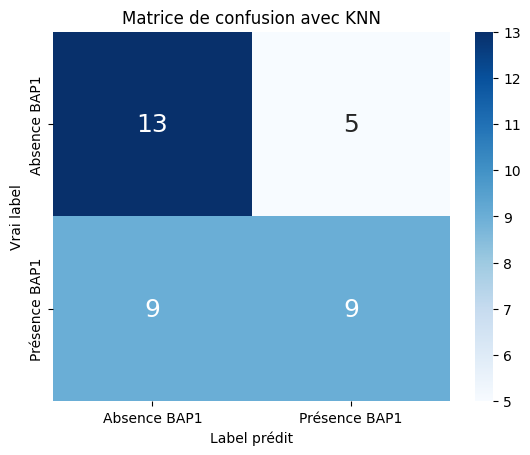

In [76]:
# K-Nearest Neighbors
knn_clf = KNeighborsClassifier(n_neighbors=13, weights='distance')

# Validation croisée sur 3 plis
cv = StratifiedKFold(n_splits=3)
scores = cross_validate(knn_clf, X, y, cv=cv, scoring=['accuracy',"recall","f1","precision"])
print(scores["test_accuracy"])
print("Accuracy avec validation croisée KNN:", np.mean(scores["test_accuracy"]).round(3), "+-", 2*np.std(scores["test_accuracy"]).round(3))

# Test
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)
print(f"Accuracy sur le jeu de test KNN: {accuracy_score(y_test, y_pred)}")
conf_matrix = confusion_matrix(y_test, y_pred,labels=[0, 1])
classes=["Absence BAP1", "Présence BAP1"]
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18}, xticklabels = classes, yticklabels = classes)
plt.title("Matrice de confusion avec KNN")
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.show()